In [331]:
import numpy as np
import matplotlib.pyplot as plt 


In [332]:
# UTILS FOR PLOTTING

def plot_velocity_field(grid_X, grid_Y, velocity_field_u, velocity_field_v, title = "Velocity Field"):
    # plt.quiver(grid_X, grid_Y, velocity_field_u, velocity_field_v, scale=20)
    plt.streamplot(grid_X, grid_Y, velocity_field_u, velocity_field_v)
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

def plot_pressure_field(grid_X, grid_Y, pressure_field, title = "Pressure Field"):
    plt.pcolormesh(grid_X, grid_Y, pressure_field, cmap="viridis", shading="auto")
    plt.colorbar(label="Pressure")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [333]:
# UTILS FOR CALCULATIONS REGARDING FLOW FIELDS

def get_divergence_of_cell(i, j, u, v): # returns float
    # should be able to consider when i and j are at the borders of the grid
    d = u[i+1][j]-u[i][j] + v[i][j+1] - v[i][j]
    return d

def get_s_sum_value_of_cell(i, j, s_field):
    s = s_field[i+1][j] + s_field[i-1][j] + s_field[i][j+1] + s_field[i][j-1]
    return s

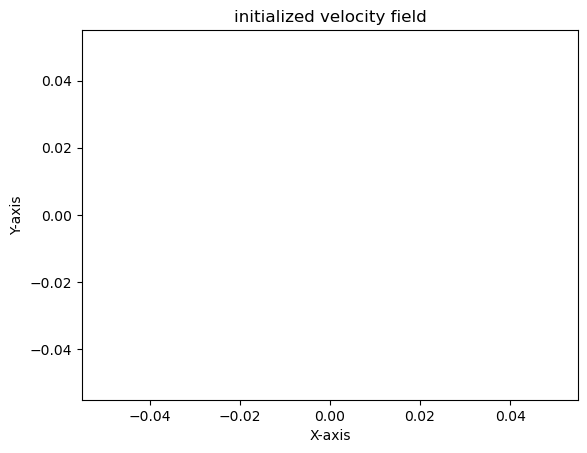

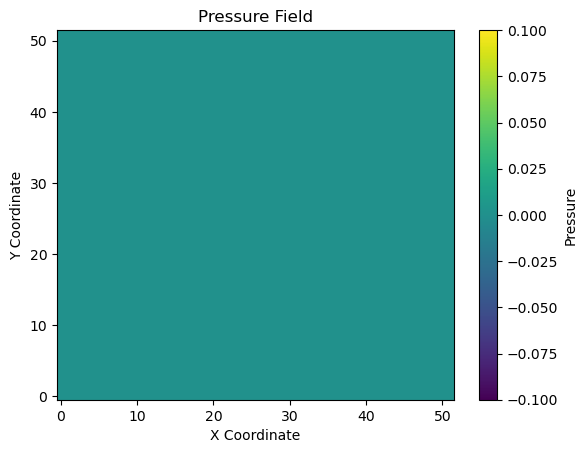

In [334]:
# INIT FIELDS 
# init grid, gravity and rho
nx = ny = 50
dx = dy = 1.0 # works when the spacing is the same
h = dx

# there would be a extra layer in the boundaries, which doesn't change its values, always zero
x = np.arange(0, (nx+2) * dx, dx) 
y = np.arange(0, (ny+2) * dy, dy)
grid_X, grid_Y = np.meshgrid(x, y) # staggered grid

g =  -9.81 # in negative y direction (downwards)
rho = 100 # density

# init velocity field:  vel_field_i = (u, v)
velocity_field_u = np.zeros_like(grid_X) 
velocity_field_v = np.zeros_like(grid_Y) 

# init pressure field:  pressure_field_ij = p_ij
pressure_field = np.zeros_like(grid_X)

# init numerical parameters
dt = 0.01
num_iterations = 10

# s field, for obstacles and walls
# s_ij = 0 -> wall, s_ij = 1 -> free space
s_field = np.ones_like(grid_X) 
s_field[:, 0] = 0  # Set the left boundary to zero
s_field[:, -1] = 0  # Set the right boundary to zero
s_field[0, :] = 0  # Set the top boundary to zero
s_field[-1, :] = 0  # Set the bottom boundary to zero

# # Create a circle in the center
# center_x, center_y = (nx+2) // 2, (ny+2) // 2
# radius = 2 
# # radius = min(nx, ny) // 4  # Adjust the radius as needed
# y, x = np.ogrid[:nx+2, :ny+2]
# mask = (x - center_y)**2 + (y - center_x)**2 <= radius**2
# s_field[mask] = 0  # Set values inside the circle to zero

# print(s_field)

# overrelaxation constant
o = 1.5

# velocity_field_v[0][0] += g*dt/2
plot_velocity_field(grid_X, grid_Y, velocity_field_u, velocity_field_v, title = "initialized velocity field")

# pressure_field[0][0] = 10
plot_pressure_field(grid_X, grid_Y, pressure_field)



[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0981     -0.0981     ... -0.02718426  0.
   0.        ]
 [ 0.         -0.0981     -0.0981     ... -0.03048356  0.
   0.        ]
 ...
 [ 0.         -0.0981     -0.0981     ... -0.00942203  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


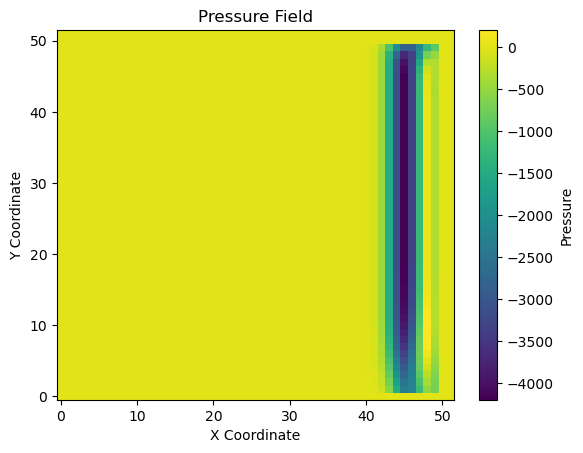

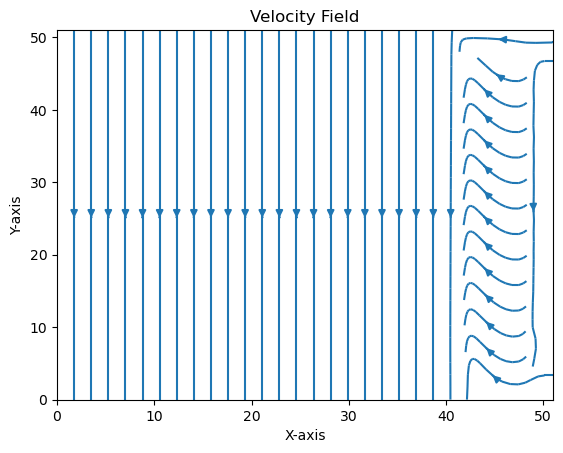

In [335]:
## ASSUMPTIONS:
# 1 - incompressible flow
# 2 - steady flow
# https://matthias-research.github.io/pages/tenMinutePhysics/index.html

cell_center_coordinates_i = nx//2
cell_center_coordinates_j = ny//2

# for iteration in range(num_iterations):

cp = rho*h/dt

# integrate
for i in range(1, ny):
    for j in range(1, nx):
        if s_field[i][j] != 0:
            velocity_field_v[i][j] += dt*g

pressure_field = np.zeros_like(grid_X)

# velocity_field_u[:, 1] = 10 

# solveIncompressibility
for _ in range(num_iterations):
    for i in range(1, ny):
        for j in range(1, nx): 
            
            # random velocity input at center cell
            # velocity_field_u[cell_center_coordinates_i][cell_center_coordinates_j] = np.random.random()
            # velocity_field_v[cell_center_coordinates_i][cell_center_coordinates_j] = np.random.random()
            # velocity_field_v[cell_center_coordinates_i][cell_center_coordinates_j] = -

            # if s_field[i][j] == 0: # wall
            #     continue
            # velocity_field_v[i][j] += dt*g
            
            sx0 = s_field[i-1][j] if 0<i-1<ny+2 else 0
            sx1 = s_field[i+1][j] if 0<i+1<ny+2 else 0
            sy0 = s_field[i][j-1] if 0<j-1<nx+2 else 0
            sy1 = s_field[i][j+1] if 0<j+1<nx+2 else 0
            s = sx0 + sx1 + sy0 + sy1
            
            if s != 0:
                d = get_divergence_of_cell(i, j, velocity_field_u, velocity_field_v) 
    
                p = -d/s
                p *= o # over-relaxation
                
                pressure_field[i][j] += cp*p  # not necessary for simulation   
    
                # p /= o
                velocity_field_u[i][j] -=  sx0 * p
                velocity_field_u[i+1][j] += sx1 * p if 0<i+1<ny+2 else 0
                velocity_field_v[i][j] -= sy0 * p
                velocity_field_u[i][j+1] += sy1 * p if 0<j+1<nx+2 else 0

# extrapolate
# for i in range(0, nx+2):
#     velocity_field_u[i][0] = velocity_field_u[i][1]
#     velocity_field_u[i][ny+1] = velocity_field_u[i][ny]
# for j in range(0, ny+2):
#     velocity_field_u[0][j] = velocity_field_u[1][j]
#     velocity_field_u[nx+1][j] = velocity_field_u[nx][j] 

# advectVel




print(velocity_field_v)
plot_pressure_field(grid_X, grid_Y, pressure_field)
        
plot_velocity_field(grid_X, grid_Y, velocity_field_u, velocity_field_v)


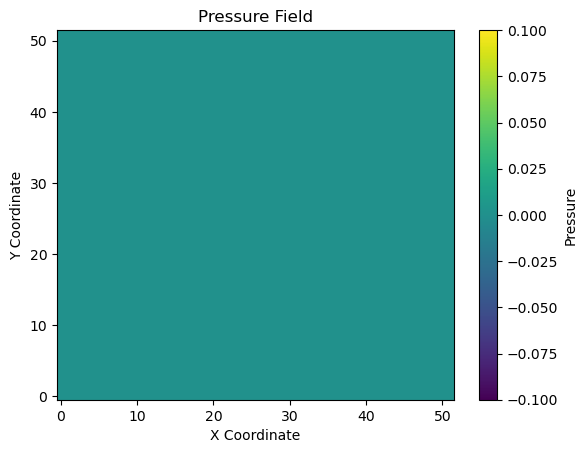

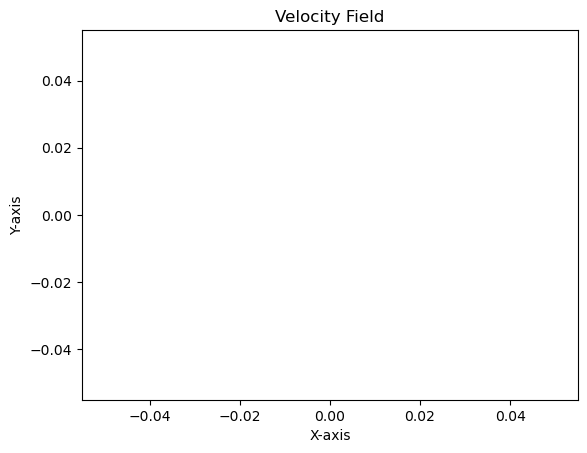

(array([], dtype=int64), array([], dtype=int64))


In [336]:
from fluid import Fluid # vector fields are arrays, not matrix why?

density = 1.0
numX = nx
numY = ny
h = 1.0
gravity = -9.81
dt = 0.1
numIters = 10

scene = Fluid(density, numX, numY, h)
for _ in range(1):
    scene.integrate(dt, gravity)
    scene.p = np.zeros_like(grid_X)
    scene.solveIncompressibility(numIters, dt)
    
    scene.extrapolate()
    scene.advectVel(dt)
    scene.advectSmoke(dt)

p_f = np.reshape(scene.p, newshape=(nx+2, ny+2))
u_f = np.reshape(scene.newU, newshape=(nx+2, ny+2))
v_f = np.reshape(scene.newV, newshape=(nx+2, ny+2))

plot_pressure_field(grid_X, grid_Y, p_f)
plot_velocity_field(grid_X, grid_Y, u_f, v_f)
print(np.nonzero(scene.p))